# Chapter 05) 트리 알고리즘

## 05-2. 교차 검증과 그리드 서치

이전까지는 문제를 간단히 하려고 테스트 세트를 사용했습니다. 하지만 테스트 세트로 일반화 성능을 올바르게 예측하려면 가능한 한 테스트 세트를 사용하지 말아야 합니다. 모델을 만들고 나서 마지막에 딱 한 번만 사용하는 것이 좋습니다. 그렇다면 max_depth 매개변수를 사용한 하이퍼파라미터 튜닝을 어떻게 할 수 있을까요? 결정 트리는 테스트해 볼 매개변수가 많습니다.
- max_depth: 트리의 최대 깊이
- min_samples_split: 내부 노드를 분할하는 데 필요한 최소 샘플 수
- min_samples_leaf: 리프 노드(말단 노드)에 필요한 최소 샘플 수
- max_features: 분할에 사용할 최대 특징 수
- criterion: 분할 품질을 평가하는 기준
- splitter: 각 노드에서 분할할 때의 전략
- max_leaf_nodes: 리프 노드의 최대 개수
- min_impurity_decrease: 불순도 감소의 최소 기준

테스트 세트를 가능한 한 사용하지 않고, 모델을 훈련하고 평가하기 위해 **교차 검증(cross-validation)**을 사용하면 됩니다. 특히 결정 트리와 같은 모델에서 하이퍼파라미터를 튜닝할 때 교차 검증을 통해 다양한 하이퍼파라미터 조합을 테스트하고 최적의 값을 찾을 수 있습니다. 이를 위해 GridSearchCV와 같은 도구를 활용할 수 있습니다.

### 검증 세트
하이퍼파라미터 튜닝을 위해 모델을 평가할 때, 테스트 세트를 사용하지 않기 위해 훈련 세트에서 다시 떼어 낸 데이터 세트

훈련 세트에서 모델을 훈련하고 검증 세트로 모델을 평가합니다. 이런 식으로 테스트하고 싶은 매개변수를 바꿔가며 가장 좋은 모델을 다시 훈련합니다. 그리고 마지막에 테스트 세트에서 최종 점수를 평가합니다. 아마도 실전에 투입했을 때 테스트 세트의 점수와 비슷한 성능을 기대할 수 있을 것입니다.

- 테스트 세트와 검증 세트에 얼마나 많은 샘플을 덜어 놔야 하나요?\
보통 20~30%를 테스트 세트와 검증 세트로 떼어 놓습니다. 하지만 문제에 따라 다릅니다. 훈련 데이터가 아주 많다면 단 몇 %만 떼어 놓아도 전체 데이터를 대표하는 데 문제가 없습니다.

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [3]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [4]:
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [5]:
print(train_input.shape, sub_input.shape, val_input.shape)

(5197, 3) (4157, 3) (1040, 3)


In [6]:
# sub_input, val_input, sub_target, val_target을 사용한 모델
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target)) # 과대적합되어 있음 > 매개변수 조정 필요

0.9971133028626413
0.864423076923077


### 교차 검증
훈련 세트를 여러 폴드로 나눈 다음 한 폴드가 검증 세트의 역할을 하고 나머지 폴드에서는 모델을 훈련합니다. 교차 검증은 모든 폴드에 대해 검증 점수를 얻어 평균하는 방법입니다.

- 3-폴드 교차 검증이 뭔가요?\
훈련 세트를 세 부분으로 나눠서 교차 검증을 수행하는 것을 3-폴드 교차 검증이라고 합니다. 통칭 k-폴드 교차 검증이라고 하며, 훈련 세트를 몇 부분으로 나누냐에 따라 다르게 부릅니다. k-겹 교차 검증이라고도 부릅니다.

검증 세트가 줄어들지만 각 폴드에서 계산한 검증 점수를 평균하기 때문에 안정된 점수로 생각할 수 있습니다. 사이킷런에는 cross_validate()라는 교차 검증 함수가 있습니다. 사용법은 간단한데, 먼저 평가할 모델 객체를 첫번째 매개변수로 전달합니다. 그다음 앞에서처럼 직접 검증 세트를 떼어 내지 않고 훈련 세트 전체를 cross_validate() 함수에 전달합니다.

사이킷런에는 cross_validate() 함수의 전신인 cross_val_score() 함수도 있습니다. 이 함수는 cross_validate() 함수의 결과 중에서 test_score 값만 반환합니다.

In [7]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.04437971, 0.02156353, 0.02643394, 0.02098322, 0.05561447]), 'score_time': array([0.00196362, 0.00893021, 0.0062964 , 0.00384736, 0.00199151]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


훈련과 검증 시간은 코랩에서 리소스를 사용하는 상황에 따라 달라질 수 있으므로 fit_time과 score_time 세트는 출력 결과가 책과 다를 수 있습니다.

In [8]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않습니다. 앞서 우리는 train_test_split() 함수로 전체 데이터를 섞은 후 훈련 세트를 준비했기 때문에 따로 섞을 필요가 없습니다. 하지만 만약 교차 검증을 할 때 훈련 세트를 섞으려면 분할기를 지정해야 합니다.

사이킷런의 분할기는 교차 검증에서 폴드를 어떻게 나눌지 결정해 줍니다. cross_validate() 함수는 기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용합니다. 즉 앞서 수행한 교차 검증은 다음 코드와 동일합니다.

In [9]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [10]:
# 훈련 세트를 섞은 후 10-폴드 교차 검증 수행
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 하이퍼파라미터 튜닝

과정; 먼저 라이브러리가 제공하는 기본값을 그대로 사용해 모델을 훈련합니다. 그다음 검증 세트의 점수나 교차 검증을 통해서 매개변수를 조금씩 바꿔 봅니다. 모델마다 적게는 1 ~ 2개에서, 많게는 5 ~ 6개의 매개변수를 제공합니다. 이 매개변수를 바꿔가면서 모델을 훈련하고 교차 검증을 수행해야 하죠.

사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행하는 기술을 'AutoML'이라고 부릅니다.

**중요한 점!** 가령 결정 트리 모델에서 최적의 max_depth 값을 찾았다고 가정해 봅시다. 그다음 max_depth를 최적의 값으로 고정하고 min_samples_split을 바꿔가며 최적의 값을 찾습니다. 이렇게 한 매개변수의 최적값을 찾고 다른 매개변수의 최적값을 찾아도 될까요? 아니요, 틀렸습니다. 불행하게도 max_depth의 최적값은 min_samples_split 매개변수의 값이 바뀌면 함께 달라집니다. 즉 이 두 매개변수를 동시에 바꿔가며 최적의 값을 찾아야 하는거죠!

게다가 매개변수가 많아지면 문제는 더 복잡해집니다. 파이썬의 for 반복문으로 이런 과정을 직접 구현할 수도 있지만, 이미 만들어진 도구를 사용하는 게 편리하겠죠? 사이킷런에서 제공하는 **그리드 서치**를 사용합시다.

그리드 서치 : 하이퍼파라미터 탐색을 자동화해 주는 도구\
탐색할 매개변수를 나열하면 교차 검증을 수행하여 가장 좋은 검증 점수의 매개변수 조합을 선택합니다. 마지막으로 이 매개변수 조합으로 최종 모델을 훈련합니다.

**GridSearchCV의 장점과 활용**\
모든 하이퍼파라미터 조합을 자동으로 테스트하여 최적값을 찾아줍니다.
여러 하이퍼파라미터를 동시에 조합하여 탐색하기 때문에 각 하이퍼파라미터 간의 상호작용도 고려할 수 있습니다.
자동화된 하이퍼파라미터 탐색을 통해 최적의 모델을 손쉽게 구축할 수 있습니다.

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [12]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
# GridSearchCV의 cv 매개변수 기본값은 5입니다. 따라서 min_impurity_decrease 값마다 5-폴드 교차 검증을 수행합니다. 결국 5*5=25개의 모델을 훈련합니다.

In [13]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [14]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [15]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [16]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [17]:
best_index = np.argmax(gs.cv_results_['mean_test_score']) # 가장 큰 값 자동으로 선택 > 인덱스 추출
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


1. 먼저 탐색할 매개변수를 지정합니다.
2. 그다음 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합을 찾습니다. 이 조합은 그리드 서치 객체에 저장됩니다.
3. 그리드 서치는 최상의 매개변수에서 (교차 검증에 사용한 훈련 세트가 아니라) 전체 훈련 세트를 사용해 최종 모델을 훈련합니다. 이 모델도 그리드 서치 객체에 저장됩니다.

In [18]:
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001), # 첫번째 매개변수 값에서 시작하여 두번째 매개변수에 도달할 때까지 세번째 매개변수를 계속 더한 배열을 만듬
          'max_depth' : range(5, 20, 1),
          'min_samples_split' : range(2, 100, 10)
          }

In [19]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [20]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [21]:
# 최상의 교차 검증 점수 확인
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


GridSearchCV 클래스를 사용하니 매개변수를 일일이 바꿔가며 교차 검증을 수행하지 않고 원하는 매개변수 값을 나열하면 자동으로 교차 검증을 수행해서 최상의 매개변수를 찾을 수 있습니다.

GridSearchCV는 각 하이퍼파라미터 값들을 고정된 간격으로 지정해야 하기 때문에, 간격 설정에 따라 최적의 매개변수를 놓치거나 탐색 범위를 비효율적으로 설정할 가능성이 있습니다.

이를 해결하기 위해, 사이킷런에서는 RandomizedSearchCV와 같은 기술을 제공하며, 최근에는 Bayesian Optimization 등 더 효율적인 최적화 기법이 많이 사용되고 있습니다.

### 랜덤 서치
연속된 매개변수 값을 탐색할 때 유용합니다. 탐색할 값을 직접 나열하는 것이 아니고 탐색 값을 샘플링할 수 있는 확률 분포 객체를 전달합니다. 지정된 횟수만큼 샘플링하여 교차 검증을 수행하기 때문에 시스템 자원이 허락하는 만큼 탐색량을 조절할 수 있습니다.

- 싸이파이(scipy)는 어떤 라이브러리인가요?\
싸이파이는 파이썬의 핵심 과학 라이브러리 중 하나입니다. 적분, 보간, 선형 대수, 확률 등을 포함한 수치 계산 전용 라이브러리입니다. 사이킷런은 넘파이와 싸이파이 기능을 많이 사용합니다. 코랩에도 이미 설치되어 있습니다.

In [22]:
from scipy.stats import uniform, randint # 주어진 범위에서 고르게 값을 뽑음

In [23]:
rgen = randint(0, 10)
rgen.rvs(10)

array([8, 4, 2, 1, 4, 4, 2, 7, 0, 2])

In [24]:
np.unique(rgen.rvs(1000), return_counts=True) # 첫 번째 배열에 나열된 각 값이 몇 번 등장했는지 나타냄

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([120, 100, 106,  86,  89,  95,  90, 101,  97, 116]))

In [25]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.56788188, 0.05802458, 0.37721395, 0.26639892, 0.87048153,
       0.53012192, 0.65567377, 0.51400804, 0.01531722, 0.8171294 ])

In [26]:
# 탐색할 매개변수
params = {'min_impurity_decrease' : uniform(0.0001, 0.001),
          'max_depth' : randint(20, 50),
          'min_samples_split' : randint(2, 25),
          'min_samples_leaf' : randint(1, 25)
          } # 샘플링 횟수는 사이킷런의 랜덤 서치 클래스인 RandomizedSearchCV의 n_iter 매개변수에 지정함

In [27]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d417b996a10>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d41b370f4c0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d417b997580>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d417d234b80>},
                   random_state=42)

In [28]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [29]:
# 최고의 교차 검증 점수 확인
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [30]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target)) # 테스트 세트 점수는 검증 세트에 대한 점수보다 조금 작은 것이 일반적

0.86


## 05-3. 트리의 앙상블

구조화된 데이터(정형 데이터)를 다루는 데 가장 뛰어난 성과를 내는 알고리즘 = 앙상블 학습 \
더 좋은 예측 결과를 만들기 위해 여러 개의 모델을 훈련하는 머신러닝 알고리즘

비정형 데이터 → 데이터베이스나 엑셀로 표현하기 어려운 것들
- 텍스트나 사진을 데이터베이스에 저장할 수는 없나요?\
저장할 수도 있습니다. 다만 여기에서는 보편적인 사례를 설명한 것입니다. 데이터베이스 중에는 구조적이지 않은 데이터를 저장하는 데 편리하도록 발전한 것이 많습니다. 대표적으로 NoSQL 데이터베이스는 엑셀이나 CSV에 담기 어려운 텍스트나 JSON 데이터를 저장하는 데 용이합니다.

### 랜덤 포레스트

: 대표적인 결정 트리 기반의 앙상블 학습 방법\
안정적인 성능 덕분에 널리 사용되고 있음\
부트스트랩 샘플을 사용하고 랜덤하게 일부 특성을 선택하여 트리를 만드는 것이 특징임

부트스트랩 : 데이터 세트에서 중복을 허용하여 데이터를 샘플링하는 방식


부트스트랩 샘플은 통계학에서 모집단으로부터 여러 번 표본을 무작위로 반복 추출해 얻은 샘플을 의미합니다. 복원 추출을 사용하는 이유는, 부트스트랩 방법이 원본 데이터의 분포를 최대한 반영하면서도 여러 개의 샘플을 만들어 모집단의 통계량을 추정하려는 목적을 가지고 있기 때문입니다. 이를 통해 작은 표본으로부터도 모집단의 특성(예: 평균, 분산, 신뢰 구간 등)을 더 정확하게 추정할 수 있습니다.

- 부트스트랩 샘플은 훈련 세트의 크기와 같게 만듬

각 노드를 분할할 때 전체 특성 중에서 일부 특성을 무작위로 고른 다음 이 중에서 최선의 분할을 찾는다. 분류 모델인 RandomForestClassifier는 기본적으로 전체 특성 개수의 제곱근만큼의 특성을 선택한다. (4개의 특성이 있으면 각 노드마다 2개 랜덤 선택)(회귀모델에서는 전체 특성 사용)

- 회귀 문제에서는 우리가 연속적인 숫자 값을 예측하고자 합니다. 랜덤 포레스트의 각 트리는 여러 변수의 일부만을 사용해 독립적으로 이 집의 가격을 예측할 것입니다. 각 트리는 조금씩 다른 예측값을 내놓겠지만, 전체적으로 비슷한 범위에서 예측할 가능성이 높습니다.\
다양한 예측값을 평균하면 극단적인 예측을 줄이고 보다 안정적인 중간값을 얻을 수 있습니다. **각 트리의 예측값 평균**은 랜덤 포레스트 회귀에서의 최종 예측값으로 사용되며, **여러 개의 트리가 협력하여 하나의 예측값**을 만듭니다.

- 분류 문제에서는 어떤 클래스에 속할 확률을 예측하는 것이 목표입니다. 각 트리는 각 클래스에 대한 확률을 독립적으로 계산할 수 있습니다.\
 **각 트리의 클래스별 확률을 평균**하면 모든 트리의 의견을 고려해 최종적인 확률을 얻을 수 있습니다. 이 평균 확률을 기반으로 가장 높은 확률을 가진 클래스를 최종 예측으로 선택합니다.



In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [32]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42) # 트리의 기본값 100개, n_jobs=-1: 가능한 모든 CPU 코어 사용 (최대 병렬 처리)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [33]:
rf.fit(train_input, train_target)
print(rf.feature_importances_) # 피처 중요도 =각 결정 트리의 피처 중요도를 평균하여 계산

[0.23167441 0.50039841 0.26792718]


OOB 샘플 : 부트스트랩 샘플에 포함되지 않고 남는 샘플 > 검증 세트의 역할을 함

In [34]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


### 엑스트라트리

랜덤 포레스트와 비슷하게 결정 트리를 사용하여 앙상블 모델을 만들지만 부트스트랩 샘플을 사용하지 않는다.\
대신 전체 특성 중 일부 특성을 랜덤하게 선택하여 노드를 분할해 과대적합을 감소시킨다.\
`splitter='random'`으로 지정

보통 엑스트라 트리가 무작위성이 좀 더 크기 때문에 랜덤 포레스트보다 더 많은 결정 트리를 훈련해야 한다.
결정 트리는 최적의 분할을 찾는 데 시간을 많이 소모한다. 특히 고려해야 할 특성의 개수가 많을 때 더 그렇다.
엑스트라 트리는 각 노드에서 특성을 랜덤하게 선택할 뿐만 아니라, 분할 지점도 무작위로 설정하여 나눈다. 이 방식은 노드마다 최적의 분할 지점을 찾는 데 시간을 소모하지 않기 때문에 랜덤 포레스트보다 훨씬 빠르게 트리를 구성할 수 있다.

In [35]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [36]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


### 그레이디언트 부스팅

: 랜덤 포레스트나 엑스트라 트리와 달리 여러 개의 **약한 학습기(결정 트리)를 순차적으로 학습**시키면서 손실 함수를 최소화하는 앙상블 방법
→ 경사 하강법을 사용하여 트리를 앙상블에 추가함

훈련 속도가 조금 느리지만 더 좋은 성능을 기대할 수 있다.

그레디언트 부스팅에서 깊이가 3인 트리 100개를 사용한다고 하면:\
각 트리는 깊이 3까지만 성장하며, 이는 개별 트리가 학습할 수 있는 패턴의 복잡도를 제한합니다.
100개의 트리는 각 트리가 순차적으로 오류를 보완해 나가는 과정에서 사용되며, 트리가 많아질수록 성능이 높아질 수 있지만 과대적합의 위험이 있습니다.
각 트리는 여전히 깊이 3으로 제한되며, 각 트리의 깊이를 더해서 "총 깊이"로 계산하지 않습니다. 대신, 전체 **모델의 복잡도**는 **트리의 개수**와 **개별 트리의 깊이에 의해 결정**됩니다.\
*모든 트리의 최대 깊이(max_depth)는 동일하게 설정

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [38]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


In [39]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15887763 0.6799705  0.16115187]


매개변수 subsample\
: **그레디언트 부스팅(Gradient Boosting)**에서 각 트리가 학습할 때 사용할 데이터의 샘플 비율을 지정하는 매개변수

subsample의 작동 방식\
subsample=1.0 (기본값): 각 트리를 학습할 때 전체 훈련 데이터를 사용합니다. 이 경우, 부스팅 방식이기 때문에 이전 모델의 잔여 오차에 대해 학습하면서 오차를 점진적으로 줄입니다.\
subsample < 1.0: 각 트리를 학습할 때 훈련 데이터의 일부만 샘플링하여 사용합니다. 예를 들어, subsample=0.8이면, 전체 데이터의 80%만 무작위로 샘플링하여 각 트리를 학습합니다.

- 과적합 방지: subsample 값을 1보다 작게 설정하면, 각 트리가 전체 데이터를 보지 않고 일부만 사용하여 학습하므로 무작위성이 증가하여 과적합을 방지하는 효과가 있습니다.
- 모델 일반화 성능 향상: 무작위 샘플링은 모델이 특정 데이터에 과적합되지 않도록 도와주며, 모델의 일반화 성능을 높이는 데 기여할 수 있습니다.
- 학습 속도 개선: 전체 데이터를 사용하지 않기 때문에, subsample 값을 낮추면 모델의 학습 속도가 빨라질 수 있습니다.

### 히스토그램 기반 부스팅

그레디언트 부스팅의 속도를 개선한 것이 히스토그램 기반 그레디언트 부스팅이며 안정적인 결과와 높은 성능으로 매우 인기가 높다.

입력 특성을 256개의 구간을 나눠, 노드를 분할할 때 최적의 분할을 매우 빠르게 찾을 수 있다.

In [40]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score'])) # 교차 검증에서 여러 폴드의 평균 점수

0.9321723946453317 0.8801241948619236


In [41]:
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean) # 평균 손실 변화량, 클수록 해당 특성이 더 중요한 것 → 합이 1이 아님

[0.08876275 0.23438522 0.08027708]


In [42]:
result = permutation_importance(hgb, test_input, test_target, n_repeats=10,
                                random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [43]:
hgb.score(test_input, test_target) # 위의 test 스코어랑 왜 다르지? 최종 모델이 테스트 세트에서 평가된 점수

0.8723076923076923

#### XGBoost

XGBoost 는 매우 효율적이고 유연하며 휴대성이 뛰어나도록 설계된 최적화된 분산 그래디언트 부스팅 라이브러리입니다. 그래디언트 부스팅 프레임워크에서 머신 러닝 알고리즘을 구현합니다 . XGBoost는 빠르고 정확한 방식으로 많은 데이터 과학 문제를 해결하는 병렬 트리 부스팅(GBDT, GBM이라고도 함)을 제공합니다. 동일한 코드가 주요 분산 환경(Hadoop, SGE, MPI)에서 실행되며 수십억 개의 예제를 넘어서는 문제를 해결할 수 있습니다.

트리 구조: XGBoost는 수평 깊이 우선 탐색 방식으로 트리를 생성합니다. 이는 각 노드가 충분히 깊어진 후에 다음 노드로 이동하며 트리를 완성하는 방식입니다.

tree_method 매개변수를 'hist'로 지정하면 히스토그램 기반 그래디언트 부스팅을 사용할 수 있습니다.

In [44]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9558403027491312 0.8782000074035686


#### LightGBM

LightGBM 은 트리 기반 학습 알고리즘을 사용하는 그래디언트 부스팅 프레임워크입니다. 분산되고 효율적이며 다음과 같은 장점이 있습니다.

- 더 빠른 훈련 속도와 더 높은 효율성
- 메모리 사용량이 적습니다.
- 더 나은 정확성
- 병렬, 분산, GPU 학습을 지원합니다.
- 대규모 데이터를 처리할 수 있습니다.

트리 구조: LightGBM은 **리프 중심 트리 성장 방식(Leaf-wise Growth)**을 사용합니다.

리프 노드(leaf node) = 트리의 가장 아래쪽에 위치한, 더 이상 자식 노드가 없는 노드들\
리프 중심 =	가장 손실이 큰 리프 노드를 선택하여 그 리프만을 확장

In [45]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


0.935828414851749 0.8801251203079884


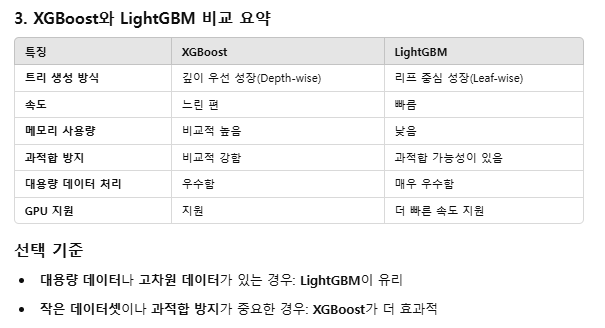

### 정리

이 알고리즘들은 모두 **결정 트리를 기반**으로 하는 **앙상블 학습 방법**이지만, 각기 다른 방식으로 모델을 구성하고 학습을 최적화합니다.

1. 랜덤 포레스트(Random Forest)\
방법: 배깅(Bagging) 방식을 사용하여 여러 개의 결정 트리를 병렬로 학습시킨 후, 개별 트리의 예측 결과를 투표(분류) 또는 평균(회귀)하여 최종 예측을 만듭니다.\
특징:
무작위성을 위해 각 트리에 사용하는 데이터 샘플을 중복 추출합니다.
각 트리의 노드 분할에서 사용할 특성의 일부만 무작위로 선택하여 최적의 분할을 찾습니다.\
장점: 병렬 학습이 가능하여 빠르게 학습할 수 있으며, 트리 간의 독립성을 통해 과적합을 방지하는 데 효과적입니다.

2. 엑스트라 트리\
방법: 랜덤 포레스트와 유사한 배깅 방식이지만, 무작위성을 더욱 강조합니다.\
특징:
각 트리의 노드 분할에서 사용할 특성을 무작위로 선택할 뿐만 아니라, 분할 지점도 무작위로 설정합니다.
전체 데이터를 샘플링 없이 사용하므로, 트리 개수를 늘려도 속도가 빠릅니다.\
장점: 더욱 간단하고 빠르게 트리를 생성하지만, 개별 트리 성능은 랜덤 포레스트보다 약할 수 있습니다. 대신 트리 수를 늘려 일반화 성능을 높입니다.

3. 그레디언트 부스팅(Gradient Boosting)\
방법: 부스팅 방식을 사용하여 이전 트리의 오차를 줄이는 방향으로 순차적으로 트리를 학습합니다.\
특징:
오차를 점진적으로 줄여나가기 위해 잔여 오차를 다음 트리가 학습하도록 합니다.
무작위성을 추가하기 위해 subsample 매개변수를 통해 데이터의 일부만 사용할 수도 있습니다.
모델이 점진적으로 개선되므로, 학습률(learning rate)과 트리 수(n_estimators)를 잘 조정해야 합니다.\
장점: 과소적합을 줄이면서 모델의 성능을 향상할 수 있지만, 순차적 학습이 필요하므로 병렬화가 어렵고, 학습 시간이 길어질 수 있습니다.

4. 히스토그램 기반 그레디언트 부스팅\
방법: 그레디언트 부스팅의 변형으로, 연속형 특성을 히스토그램 형태로 구간화하여 학습 속도를 높입니다.\
특징:
연속형 특성을 히스토그램으로 변환한 후, 각 구간에 대해 최적 분할을 찾으므로 메모리 사용량과 연산 속도가 개선됩니다.
HistGradientBoostingClassifier 및 HistGradientBoostingRegressor와 같은 Scikit-Learn 구현 또는 LightGBM, XGBoost에도 유사한 방법이 사용됩니다.\
장점: 대규모 데이터셋에서 빠르고 효율적입니다. 특히 LightGBM과 XGBoost의 학습 속도에 큰 기여를 합니다.

5. XGBoost (Extreme Gradient Boosting)\
방법: 그레디언트 부스팅의 개선된 형태로, 히스토그램 기반 학습과 다양한 최적화 기법을 포함하여 빠르고 효과적인 부스팅 모델을 제공합니다.\
특징:
정규화 옵션을 추가하여 과적합을 방지합니다.
병렬 처리를 통해 학습 속도를 개선합니다.
자체적으로 결측값 처리가 가능하고, 조기 종료(early stopping) 기능으로 학습을 자동으로 조절할 수 있습니다.\
장점: 성능이 우수하며, 대규모 데이터셋과 높은 차원의 특성에 대해 빠르게 학습할 수 있습니다.

6. LightGBM (Light Gradient Boosting Machine)\
방법: Microsoft가 개발한 그레디언트 부스팅 알고리즘으로, 히스토그램 기반 학습과 리프 중심의 트리 성장 방식을 사용하여 매우 빠르게 학습합니다.\
특징:
리프 중심 성장 방식은 손실이 큰 리프 노드를 우선적으로 분할하므로, 트리 성장이 불균형하지만 성능이 높습니다.
데이터 샘플링과 조기 종료 기능을 통해 과적합을 방지할 수 있습니다.\
장점: 대규모 데이터와 고차원 특성에 대해 학습이 빠르고, 메모리 효율이 뛰어나며, 모델 성능도 높습니다.

**랜덤 포레스트**와 **엑스트라 트리**는 배깅 방식으로 독립적으로 트리를 생성하여 병렬 학습이 가능하고, 과적합을 방지하기 위해 무작위성을 추가합니다.

**그레디언트 부스팅, XGBoost, LightGBM**은 부스팅 방식으로 이전 트리의 오차를 점진적으로 줄여나가며 학습하여 성능을 개선합니다.
→ XGBoost와 LightGBM은 그레디언트 부스팅을 개선한 버전으로, 학습 속도와 메모리 사용 효율을 크게 개선한 고성능 부스팅 기법입니다.

**히스토그램 기반 그레디언트 부스팅**은 연속형 특성을 히스토그램으로 구간화하여 연산 속도와 메모리 사용을 최적화한 방식이며, 대규모 데이터에서 부스팅 기법을 효율적으로 구현합니다.\
→ 대규모 데이터나 고차원 데이터에서는 XGBoost와 LightGBM이 자주 사용되고, 상대적으로 작은 데이터셋에서는 랜덤 포레스트가 과적합을 방지하면서도 안정적인 성능을 보여줍니다.